# Part 0: Raw Data & Environment Set-up

## Raw Data

The following code loads in and unzips the raw data. Raw data has been downloaded from Kaggle placed into public Google Cloud Storage for ease of access.

In [1]:
# Loads in steam-reviews.zip (game reviews)
url1 = ("https://storage.googleapis.com/dsc232r-group-project-data/steam-reviews.zip")
!wget "{url1}"

--2025-05-11 22:31:34--  https://storage.googleapis.com/dsc232r-group-project-data/steam-reviews.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.72.251, 142.250.189.27, 172.217.12.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.72.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17241297932 (16G) [application/x-zip-compressed]
Saving to: ‘steam-reviews.zip’

steam-reviews.zip   100%[===================>]  16.06G   105MB/s    in 2m 36s  

2025-05-11 22:34:11 (106 MB/s) - ‘steam-reviews.zip’ saved [17241297932/17241297932]



In [2]:
# Extracts steam-reviews.zip into specified directory and deletes .zip file
!unzip steam-reviews.zip -d /home/joneel/joneel/Group_Project/raw_data/steam-reviews && rm steam-reviews.zip

Archive:  steam-reviews.zip
  inflating: /home/joneel/joneel/Group_Project/raw_data/steam-reviews/all_reviews/all_reviews.csv  
  inflating: /home/joneel/joneel/Group_Project/raw_data/steam-reviews/weighted_score_above_08.csv  


In [3]:
# Loads in games.csv (games metadata)
url2 = ("https://storage.googleapis.com/dsc232r-group-project-data/games.csv")
!wget "{url2}"

--2025-05-11 22:40:04--  https://storage.googleapis.com/dsc232r-group-project-data/games.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.72.187, 142.250.72.251, 172.217.12.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.72.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468641107 (447M) [application/vnd.ms-excel]
Saving to: ‘games.csv’

games.csv           100%[===================>] 446.93M   115MB/s    in 4.3s    

2025-05-11 22:40:08 (103 MB/s) - ‘games.csv’ saved [468641107/468641107]



In [4]:
# Moves games.csv into specified directory
!mv games.csv /home/joneel/joneel/Group_Project/raw_data

## Environment Set-up

Set-up on the cluster included 60 cores with 128GB memory in order to load and process this dataset.

In [5]:
# Import required libraries
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /scratch/joneel/job_39293350/matplotlib-kt_8ufbi because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
# sc.stop() # To stop a currently running SparkSession, if needed for troubleshooting/development

In [7]:
# Establishes Spark Session
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
	.config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "15") \
    .config("spark.executor.cores", "4") \
	.appName("MySparkJob") \
	.getOrCreate()

# Part 1: Load Data into Spark Dataframes & Pre-processing

## 1.a. Reviews Data (from [“100 Million+ Steam Reviews”](https://www.kaggle.com/datasets/kieranpoc/steam-reviews/data) dataset)

In [8]:
# Loads all_reviews.csv file into a spark dataframe
reviews_df = sc.read.csv("/home/joneel/joneel/Group_Project/raw_data/steam-reviews/all_reviews/all_reviews.csv", header=True, inferSchema=True)

In [9]:
# Displays reviews_df schema and counts total # of reviews
reviews_df.printSchema()
print(f"Number of reviews: {reviews_df.count()}")

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: string (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- writt

In [10]:
# Removes two columns related to Chinese gaming market (not relevant for this analysis)
reviews_df = reviews_df.drop("hidden_in_steam_china", "steam_china_location")
reviews_df.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: string (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- writt

In [11]:
# Filters dataframe to include only reviews in English & counts new number of reviews
reviews_df_processed = reviews_df.filter(reviews_df.language == 'english')
reviews_df_processed.select("language").distinct().show()
print(f"Number of reviews: {reviews_df_processed.count()}")

+--------+
|language|
+--------+
| english|
+--------+

Number of reviews: 51544179


In [12]:
# Drops rows that contain null values in the id or reviews column & drop duplicate recommendation ids
reviews_df_processed = reviews_df_processed.na.drop(subset=["recommendationid", "appid", "author_steamid", "review"])
print(f"Number of reviews: {reviews_df_processed.count()}")
reviews_df_processed = reviews_df_processed.dropDuplicates(subset=["recommendationid"])
print(f"Number of reviews: {reviews_df_processed.count()}")

Number of reviews: 51544179
Number of reviews: 51351970


In [13]:
# Cast columns to appropriate datatypes based on definitions on Kaggle
reviews_df_processed = reviews_df_processed.withColumn("author_num_games_owned", f.col("author_num_games_owned").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_num_reviews", f.col("author_num_reviews").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_forever", f.col("author_playtime_forever").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_last_two_weeks", f.col("author_playtime_last_two_weeks").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_playtime_at_review", f.col("author_playtime_at_review").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("author_last_played", f.from_unixtime(f.col("author_last_played")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("timestamp_created", f.from_unixtime(f.col("timestamp_created")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("timestamp_updated", f.from_unixtime(f.col("timestamp_updated")).cast("timestamp"))
reviews_df_processed = reviews_df_processed.withColumn("voted_up", f.col("voted_up").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("votes_up", f.col("votes_up").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("votes_funny", f.col("votes_funny").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("weighted_vote_score", f.col("weighted_vote_score").cast("double"))
reviews_df_processed = reviews_df_processed.withColumn("comment_count", f.col("comment_count").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("steam_purchase", f.col("steam_purchase").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("received_for_free", f.col("received_for_free").cast("integer"))
reviews_df_processed = reviews_df_processed.withColumn("written_during_early_access", f.col("written_during_early_access").cast("integer"))
reviews_df_processed.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- voted_up: integer (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: integer (nullable = true)
 |-- received_for_free: integer (nullabl

In [14]:
# Fixing Boolean columns
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["steam_purchase"] == 0) | (reviews_df_processed["steam_purchase"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["received_for_free"] == 0) | (reviews_df_processed["received_for_free"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["written_during_early_access"] == 0) | 
                                                   (reviews_df_processed["written_during_early_access"] == 1))
reviews_df_processed = reviews_df_processed.filter((reviews_df_processed["voted_up"] == 0) | (reviews_df_processed["voted_up"] == 1))
reviews_df_processed = reviews_df_processed.withColumnRenamed("voted_up","positive_review")

# Cast to boolean
reviews_df_processed = reviews_df_processed.withColumn("steam_purchase", f.col("steam_purchase").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("received_for_free", f.col("received_for_free").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("written_during_early_access", f.col("written_during_early_access").cast("boolean"))
reviews_df_processed = reviews_df_processed.withColumn("positive_review", f.col("positive_review").cast("boolean"))

print(f"Number of reviews: {reviews_df_processed.count()}")

Number of reviews: 49606273


In [15]:
# Filter review dates from before September 12, 2003 (when Steam was launched)
reviews_df_processed = reviews_df_processed.filter(reviews_df_processed.timestamp_created >= '2003-09-12')
reviews_df_processed = reviews_df_processed.filter(reviews_df_processed.timestamp_updated >= '2003-09-12')

In [16]:
# Double check schema and print new review count
reviews_df_processed.printSchema()
print(f"Number of reviews: {reviews_df_processed.count()}")

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- positive_review: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (

In [17]:
# Splits data into two dataframes, 1 with all the review metadata and 1 with only the recommendationid + appid + review
reviews_df_processed_metadata = reviews_df_processed.drop("review")
reviews_df_processed_reviews = reviews_df_processed.select("recommendationid", "appid", "review")

## 1.b. Games Data (from ["Steam Games"](https://www.kaggle.com/datasets/artermiloff/steam-games-dataset) dataset)

In [18]:
# Loads games.csv file into a spark dataframe
games_df = sc.read.csv("/home/joneel/joneel/Group_Project/raw_data/games.csv", header=True, inferSchema=True)

In [19]:
# Displays games_df schema and counts total # of games
games_df.printSchema()
print(f"Number of games: {games_df.count()}")

root
 |-- appid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- required_age: string (nullable = true)
 |-- price: string (nullable = true)
 |-- dlc_count: double (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- website: string (nullable = true)
 |-- support_url: string (nullable = true)
 |-- support_email: string (nullable = true)
 |-- windows: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- metacritic_score: string (nullable = true)
 |-- metacritic_url: string (nullable = true)
 |-- achievements: string (nullable = true)
 |-- recommendations: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- supported_languages: string (nullable = true)
 |-- full_audi

In [20]:
# Removes columns not relevant for this analysis
games_df_processed = games_df.drop("reviews", "header_image", "website", "support_url", "support_email", "full_audio_languages", "screenshots", "movies",
                                  "required_age", "metacritic_url", "supported_languages", "packages", "score_rank", "discount")
games_df_processed.printSchema()

root
 |-- appid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- dlc_count: double (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- windows: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- metacritic_score: string (nullable = true)
 |-- achievements: string (nullable = true)
 |-- recommendations: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- developers: string (nullable = true)
 |-- publishers: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- user_score: string (nullable = true)
 |-- positive: string (nullable = true)
 |-- negative: string (nullable = true)
 |-- estimated_owners: string (nullable = true)
 |-- average_playtime_forever: 

In [21]:
# Drops rows that contain null values or duplicates in the appid column
print(f"Number of games: {games_df_processed.count()}")
games_df_processed = games_df_processed.na.drop(subset=["appid"])
print(f"Number of games: {games_df_processed.count()}")
games_df_processed = games_df_processed.dropDuplicates(subset=["appid"])
print(f"Number of games: {games_df_processed.count()}")

Number of games: 89618
Number of games: 89618
Number of games: 89618


In [22]:
# Cast columns to appropriate data types based ond descriptions on Kaggle
games_df_processed = games_df_processed.withColumn("release_date", f.to_timestamp("release_date", "yyyy-MM-dd"))
games_df_processed = games_df_processed.withColumn("price", f.col("price").cast("double"))
games_df_processed = games_df_processed.withColumn("dlc_count", f.col("dlc_count").cast("integer"))
games_df_processed = games_df_processed.withColumn("windows", f.col("windows").cast("boolean"))
games_df_processed = games_df_processed.withColumn("mac", f.col("mac").cast("boolean"))
games_df_processed = games_df_processed.withColumn("linux", f.col("linux").cast("boolean"))
games_df_processed = games_df_processed.withColumn("metacritic_score", f.col("metacritic_score").cast("double"))
games_df_processed = games_df_processed.withColumn("achievements", f.col("achievements").cast("integer"))
games_df_processed = games_df_processed.withColumn("recommendations", f.col("recommendations").cast("integer"))
games_df_processed = games_df_processed.withColumn("user_score", f.col("user_score").cast("integer"))
games_df_processed = games_df_processed.withColumn("positive", f.col("positive").cast("integer"))
games_df_processed = games_df_processed.withColumn("negative", f.col("negative").cast("integer"))
games_df_processed = games_df_processed.withColumn("average_playtime_forever", f.col("average_playtime_forever").cast("integer"))
games_df_processed = games_df_processed.withColumn("average_playtime_2weeks", f.col("average_playtime_2weeks").cast("integer"))
games_df_processed = games_df_processed.withColumn("median_playtime_forever", f.col("median_playtime_forever").cast("integer"))
games_df_processed = games_df_processed.withColumn("median_playtime_2weeks", f.col("median_playtime_2weeks").cast("integer"))
games_df_processed = games_df_processed.withColumn("pct_pos_total", f.col("pct_pos_total").cast("integer"))
games_df_processed = games_df_processed.withColumn("peak_ccu", f.col("peak_ccu").cast("integer"))
games_df_processed = games_df_processed.withColumn("num_reviews_total", f.col("num_reviews_total").cast("integer"))
games_df_processed = games_df_processed.withColumn("pct_pos_recent", f.col("pct_pos_recent").cast("integer"))
games_df_processed = games_df_processed.withColumn("num_reviews_recent", f.col("num_reviews_recent").cast("integer"))
games_df_processed.printSchema()

root
 |-- appid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- dlc_count: integer (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- windows: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- metacritic_score: double (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- notes: string (nullable = true)
 |-- developers: string (nullable = true)
 |-- publishers: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- user_score: integer (nullable = true)
 |-- positive: integer (nullable = true)
 |-- negative: integer (nullable = true)
 |-- estimated_owners: string (nullable = true)
 |-- average_playti

## 1.c. Checking Compatibility of Datasets

In [23]:
# Verify that appid's match between the two datasets
joined = reviews_df_processed_metadata.select("appid", "game").alias("df1").join(
    games_df_processed.select("appid", "name").alias("df2"), on="appid", how="inner").filter(
    "df1.game != df2.name")
joined.show()

+-------+--------------------+--------------------+
|  appid|                game|                name|
+-------+--------------------+--------------------+
|1172380|STAR WARS Jedi: F...|STAR WARS Jedi: F...|
|1172620|      Sea of Thieves|Sea of Thieves: 2...|
|1172470|        Apex Legends|       Apex Legends™|
| 289070|Sid Meier's Civil...|Sid Meier’s Civil...|
| 271590|  Grand Theft Auto V|Grand Theft Auto ...|
| 391220|Rise of the Tomb ...|Rise of the Tomb ...|
|1238860|     Battlefield 4™ |      Battlefield 4™|
| 252950|       Rocket League|      Rocket League®|
|1313860| EA SPORTS™ FIFA 21 |  EA SPORTS™ FIFA 21|
|1222680|Need for Speed™ H...|Need for Speed™ Heat|
|1238020|Mass Effect 3 (2012)|Mass Effect™ 3 N7...|
| 555160|           Pavlov VR|              Pavlov|
|1481400|               Dagon|Dagon: by H. P. L...|
|1172620|      Sea of Thieves|Sea of Thieves: 2...|
| 444090|            Paladins|           Paladins®|
|1239080|      Door Kickers 2|Door Kickers 2: T...|
|1172470|   

In [24]:
# Dropping the game name from the first dataset (100+ Million Reviews), will use the game name from the second dataset (Steam Games)
reviews_df_processed_metadata = reviews_df_processed_metadata.drop("game")

## 1.d. Final Pre-processed Data Frames

In [25]:
print("Final Processed Dataframes: ")
print("Reviews Metadata (reviews_df_processed_metadata): ")
reviews_df_processed_metadata.printSchema()
print("Reviews (reviews_df_processed_reviews): ")
reviews_df_processed_reviews.printSchema()
print("Games (games_df_processed): ")
games_df_processed.printSchema()

Final Processed Dataframes: 
Reviews Metadata (reviews_df_processed_metadata): 
root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- positive_review: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boo

In [26]:
# Save processed dataframes as parquet files
#reviews_df_processed_metadata.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/reviews_processed_metadata")
#reviews_df_processed_reviews.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/reviews_processed")
#games_df_processed.write.mode("overwrite").parquet("joneel/Group_Project/processed_data/games_processed")

In [27]:
# Cache most used dataframe
#reviews_df_processed_metadata.persist(StorageLevel.MEMORY_AND_DISK)
#reviews_df_processed_metadata.count()

# Part 2: Exploratory Plots & Summary Statistics

## 2.a. Summary Statistics

In [28]:
# Total # Reviews, Total # Games Reviewed, and Total # Unique Reviewers
print(f"Number of Reviews: {reviews_df_processed_metadata.count()}")
num_games_reviewed = reviews_df_processed_metadata.select("appid").distinct().count()
print(f"Number of Games Reviewed: {num_games_reviewed}")
num_unique_reviewers = reviews_df_processed_metadata.select("author_steamid").distinct().count()
print(f"Number of Unique Reviewers: {num_unique_reviewers}")
# Date range of Reviews
print("Date Range of Reviews: ")
reviews_df_processed_metadata.select(f.min("timestamp_created").alias("earliest_review"), 
                                     f.max("timestamp_created").alias("latest_review")).show()

Number of Reviews: 49606243
Number of Games Reviewed: 96042
Number of Unique Reviewers: 15314376
Date Range of Reviews: 
+-------------------+-------------------+
|    earliest_review|      latest_review|
+-------------------+-------------------+
|2010-10-15 22:24:52|2023-11-03 16:16:25|
+-------------------+-------------------+



## 2.b. Exploratory Plots

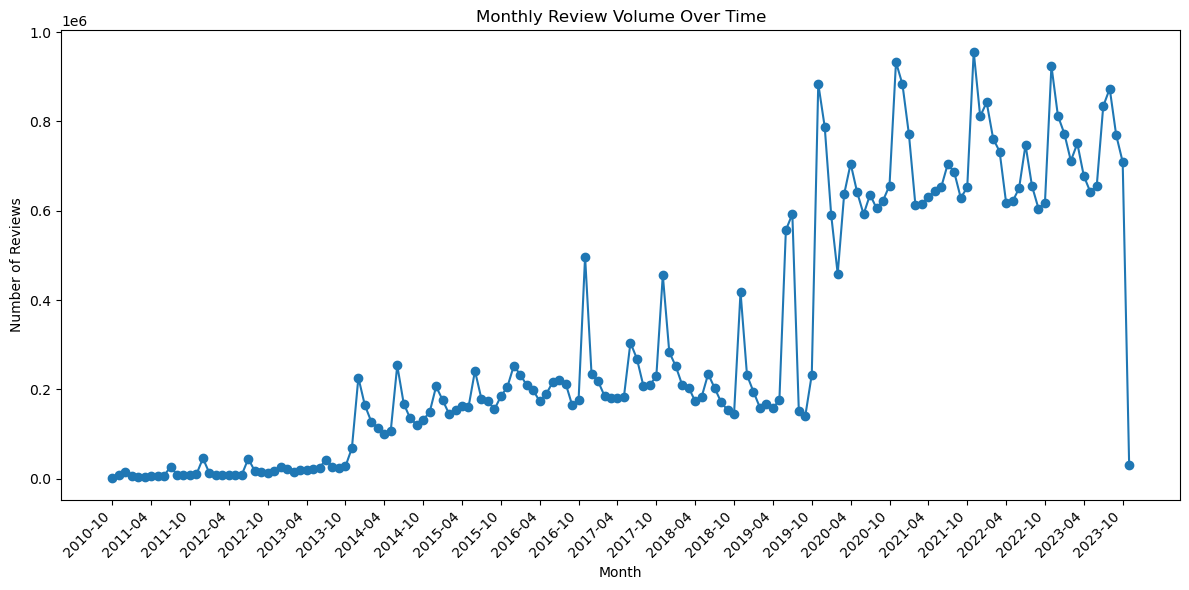

In [29]:
# Review Volume Over Time
# Reduce data to pandas dataframe
reviews_by_month = reviews_df_processed_metadata.withColumn("year_month", f.date_format("timestamp_created", "yyyy-MM"))
review_counts_by_month = reviews_by_month.groupBy("year_month").count().orderBy("year_month")
review_counts_pd = review_counts_by_month.toPandas()
# Line plot - Review Volume Over Time
plt.figure(figsize=(12,6))
plt.plot(review_counts_pd["year_month"], review_counts_pd["count"], marker="o")
plt.xticks(ticks=review_counts_pd.index[::6], labels=review_counts_pd["year_month"][::6], rotation=45, ha="right")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Review Volume Over Time")
plt.tight_layout()
plt.show()

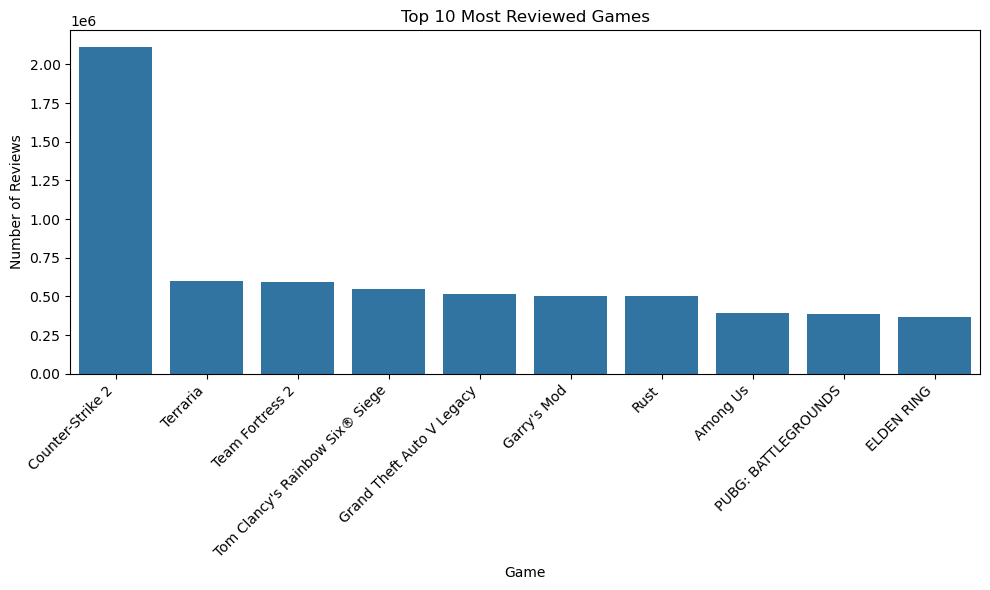

In [30]:
# Plot Most-Reviewed Games (Top 10) - Bar Chart
# Reduce data to pandas dataframe
review_counts = reviews_df_processed_metadata.groupBy("appid").count()
review_counts_named = review_counts.join(games_df_processed.select("appid", "name"), on="appid", how="left")
top_10_games = review_counts_named.orderBy(f.col("count").desc()).limit(10)
top_10_games_pd = top_10_games.toPandas()
# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_games_pd, x="name", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Most Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

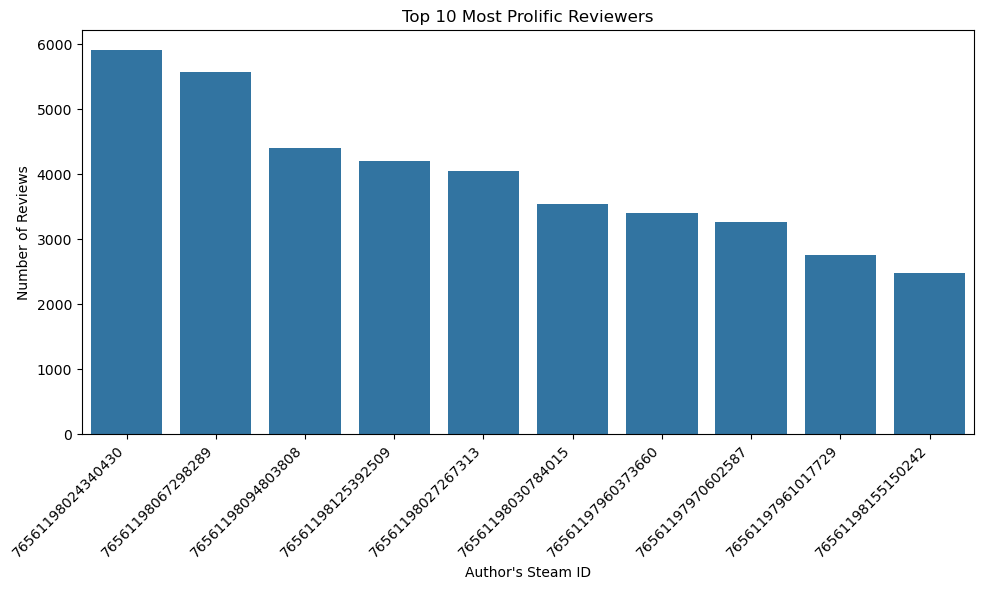

In [31]:
# Plot Most Prolific Reviewers (Top 10) - Bar Chart
# Reduce data to pandas dataframe
reviewer_counts = reviews_df_processed_metadata.groupBy("author_steamid").count()
top_10_reviewers = reviewer_counts.orderBy(f.col("count").desc()).limit(10)
top_10_reviewers_pd = top_10_reviewers.toPandas()
# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_reviewers_pd, x="author_steamid", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Most Prolific Reviewers")
plt.xlabel("Author's Steam ID")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# Top 10 Best & Worst Reviewed Games
# Reduce data to pandas dataframe
review_stats = reviews_df_processed_metadata.withColumn("positive_review", f.col("positive_review").cast("integer")) \
                    .groupBy("appid") \
                    .agg(
                        f.avg("positive_review").alias("positive_ratio"),
                        f.count("*").alias("total_reviews")
                    )
review_stats_filtered = review_stats.filter("total_reviews >= 10000")
review_stats_named = review_stats_filtered.join(games_df_processed.select("appid", "name"), on="appid", how="left")
review_stats_named = review_stats_named.filter((review_stats_named.name != "None") & (review_stats_named.name.isNotNull()))
top_10_best_games = review_stats_named.orderBy("positive_ratio", ascending=False).limit(10)
top_10_best_games_pd = top_10_best_games.toPandas()
top_10_worst_games = review_stats_named.orderBy("positive_ratio", ascending=True).limit(10)
top_10_worst_games_pd = top_10_worst_games.toPandas()

# Plot bar chart - Top 10 Best Games
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_best_games_pd, x="name", y="positive_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Best Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Proportion of Positive Reviews")
plt.ylim(0.975, 1.0)
plt.tight_layout()
plt.show()

# Plot bar chart - Top 10 Worst Games
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_worst_games_pd, x="name", y="positive_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Worst Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Proportion of Positive Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# Positivity Rate vs. Playtime at Time of Review
# Reduce data to pandas dataframe
reviews_binned = reviews_df_processed_metadata.withColumn("playtime_bin", f.floor(f.col("author_playtime_at_review") / 100) * 100)
reviews_binned = reviews_binned.withColumn("is_positive_int", f.col("positive_review").cast("integer"))
playtime_vs_positive = reviews_binned.groupBy("playtime_bin") \
        .agg(
            f.avg("is_positive_int").alias("positive_ratio"),
            f.count("*").alias("review_count")
        ) \
        .orderBy("playtime_bin")
playtime_vs_positive = playtime_vs_positive.limit(200)
playtime_vs_positive_pd = playtime_vs_positive.toPandas()
# Plot scatter plot - Positivity Rate vs. Playtime at Time of Review
plt.figure(figsize=(10,6))
plt.plot(playtime_vs_positive_pd["playtime_bin"], playtime_vs_positive_pd["positive_ratio"], marker="o")
plt.xlabel("Playtime at Review (minutes, binned)")
plt.ylabel("Proportion of Positive Reviews")
plt.title("Positivity Rate vs. Playtime at Time of Review")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# To-do:
# Tokenize reviews, break down tags and genres
# Word cloud of reviews (positive vs. negative)